In [46]:
# Importing libraries
from random import sample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.max_columns', 200)

In [47]:
# Loading the dataset
data = pd.read_csv('training_v2.csv')

## Data Preprocessing
### Class Imbalance
We find that this dataset is hugely imbalanced. There are very few observations of `hospital_death` = 1 as compared to `hospital_death` = 0. Once presented with previously unseen data, this can prove to be a problem since classification algorithms might classify all the entries as `hospital_death` = 0 in order to obtain a high accuracy. 

In [48]:
# Extracting the counts for each level of the target feature
data['hospital_death'].value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

### Resampling 

Resampling, as the name suggests, allows us to obtain a different sample of the data so as to ensure that both classes in our target variable are evenly distributed. Since we have almost 100,000 records in the dataset, we choose **downsampling technique** so that our dataset is reduced to something more manageable thereby also speeding up our first iteration of modeling. 

In [49]:
# Extracting the rows where hospital == 0
alive_data = data[data['hospital_death'] == 0].reset_index(drop=True)

# Generating indexes from 0 to 83798
idx = list(range(0,83798))

# Subset a sample without replacement from the indexes
subset = sample(idx, 7915)

# Subsetting the alive_data with the chosen indexes, reseting the index
alive_data = alive_data.loc[subset].reset_index(drop=True)

In [50]:
# Appending the alive_data with the observations where hospital_death == 1
new_data = alive_data.append(data[data['hospital_death'] == 1])

# Shuffling the dataset so the distribution of 0 and 1 is random throughout the dataset
new_data = new_data.sample(frac=1).reset_index(drop=True)

In [51]:
new_data.shape

(15830, 186)

In [52]:
new_data.head(20)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,128792,123073,37,0,66.0,22.782294,0,Other/Unknown,M,165.1,NaN,Operating Room / Recovery,685,admit,Med-Surg ICU,0.212500,0,62.1,3.4,214.0,1401.01,1,0.0,1.0,17.0,0.82,NaN,4.0,6.0,0.0,5.0,125.0,106.0,NaN,0.0,56.0,NaN,NaN,NaN,NaN,29.0,136.0,37.50,986.2560,0.0,NaN,NaN,NaN,80.0,56.0,80.0,56.0,106.0,94.0,NaN,NaN,113.0,69.0,113.0,69.0,19.0,18.0,99.0,95.0,NaN,NaN,153.0,101.0,153.0,101.0,37.5,37.10,NaN,NaN,80.0,80.0,80.0,80.0,94.0,94.0,NaN,NaN,113.0,113.0,113.0,113.0,18.0,18.0,95.0,95.0,NaN,NaN,153.0,153.0,153.0,153.0,NaN,NaN,3.4,2.9,1.2,1.0,17.0,14.00,8.5,7.1,1.08,0.82,125.0,95.0,NaN,NaN,11.4,11.4,34.6,34.6,NaN,NaN,NaN,NaN,198.0,198.0,4.0,3.9,139.0,136.0,10.40,10.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal
1,981,60479,8,1,NaN,25.596516,0,African American,M,178.0

### Split the feature variables and the target variable

In [53]:
X = new_data.drop('hospital_death', axis = 1)
y = new_data['hospital_death']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15830 entries, 0 to 15829
Columns: 185 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(7), object(8)
memory usage: 22.3+ MB


### Missing values
This dataset contains a lot of missing values and we've employed various strategies throughout the notebook to deal with them. We first start with: 
1. **Drop rows that contain missing values greater than a 50% threshold.**
2. **Use the index of the rows in step 1 to drop the respective values from the target variable column.**

In [54]:
# Look at the row-wise percentage of missing values in X
X.isnull().mean(axis = 1)

0        0.400000
1        0.567568
2        0.270270
3        0.583784
4        0.194595
5        0.545946
6        0.232432
7        0.270270
8        0.286486
9        0.145946
10       0.372973
11       0.340541
12       0.378378
13       0.335135
14       0.291892
15       0.102703
16       0.275676
17       0.221622
18       0.502703
19       0.378378
20       0.410811
21       0.410811
22       0.172973
23       0.351351
24       0.340541
25       0.394595
26       0.243243
27       0.270270
28       0.454054
29       0.270270
           ...   
15800    0.394595
15801    0.108108
15802    0.102703
15803    0.270270
15804    0.205405
15805    0.394595
15806    0.394595
15807    0.259459
15808    0.372973
15809    0.378378
15810    0.567568
15811    0.518919
15812    0.545946
15813    0.145946
15814    0.362162
15815    0.475676
15816    0.394595
15817    0.345946
15818    0.378378
15819    0.329730
15820    0.367568
15821    0.400000
15822    0.151351
15823    0.183784
15824    0

In [55]:
# Obtaining the index values of rows where 50% or more of the data is missing
idx = X.index[X.isnull().mean(axis=1) > 0.5].tolist()

# Dropping rows from X
row_majority_X = X.drop(X.index[idx]).reset_index(drop=True)
print("The shape of X after dropping rows is {}".format(row_majority_X.shape))

# Dropping corresponding rows from y
final_y = y.drop(y.index[idx]).reset_index(drop=True)
print("The shape of y after dropping rows is {}".format(final_y.shape))

The shape of X after dropping rows is (14631, 185)
The shape of y after dropping rows is (14631,)


### Dimensionality Reduction

We follow 2 strategies in order to reduce the number of dimensions in our dataset.
1. **Drop columns that contain missing values greater than a 75% threshold:**
> For example, the column `h1_pao2fio2ratio_min` is missing 83.5% of its data. 
2. **Drop coloumns based on manual evaluation of the data:**
> For example, drop the `id` columns since they don't provide any relevant information in predicting `hospital_death`.
Additionally, drop the `height` and `weight` columns since they are both explained by the `bmi` column.

In [56]:
# Look at the column-wise percentage of missing values in X
row_majority_X.isnull().mean()

encounter_id                     0.000000
patient_id                       0.000000
hospital_id                      0.000000
age                              0.055294
bmi                              0.038480
elective_surgery                 0.000000
ethnicity                        0.013465
gender                           0.000410
height                           0.015447
hospital_admit_source            0.228898
icu_admit_source                 0.001025
icu_id                           0.000000
icu_stay_type                    0.000000
icu_type                         0.000000
pre_icu_los_days                 0.000000
readmission_status               0.000000
weight                           0.028638
albumin_apache                   0.504613
apache_2_diagnosis               0.010936
apache_3j_diagnosis              0.007723
apache_post_operative            0.000000
arf_apache                       0.004374
bilirubin_apache                 0.550748
bun_apache                       0

In [57]:
# Retain only those columns where missing values are less than 75%
column_majority_X = row_majority_X[row_majority_X.columns[row_majority_X.isnull().mean() < 0.75]]
column_majority_X.shape

(14631, 149)

In [58]:
# Drop columns based on manual evaluation of data
final_X = column_majority_X.drop(columns=['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'height', 'weight'], axis=1)
print("The shape of X after dropping columns is {}".format(final_X.shape))

The shape of X after dropping columns is (14631, 143)


### Split categorical and numerical variables

In [59]:
def num_cat_col(df):
    '''
    Splits the columns of the dataframe into categorical and numerical columns 
    and returns them as 2 separate lists.
    Columns having binary values (0 or 1) are added to the list of categorical columns.
    '''
    num_col = []
    cat_col = []
    dictionary = pd.read_csv('WiDS Datathon 2020 Dictionary.csv')
    new_dictionary = dictionary[dictionary['Data Type'] == 'binary']
    
    for column in df.columns:
        if df[column].dtypes == 'object':
            cat_col.append(column)
        elif column in [value for key, value in new_dictionary['Variable Name'].iteritems()]:
            cat_col.append(column)
        else:
            num_col.append(column)
    return cat_col, num_col

cat_col, num_col = num_cat_col(final_X)

### Dealing with categorical variables

There are still some missing values that need to be taken care of among our categorical variables so we evaluate them in order:
1. **ethnicity** 
> Impute the missing values with 'Undisclosed'.
2. **gender** 
> Impute the missing values with 'Undisclosed'.
3. **hospital_admit_source** and **icu_admit_source**
> On evaluating the 2 columns side by side, we find that `icu_admit_source` is conveying similar information as `hospital_admit_source` and also has fewer missing values than `hospital_admit_source`. Therefore we decide to drop `hospital_admit_source` and impute the missing values of `icu_admit_source` wuth 'Unknown'.
4. **apache_3j_bodysystem** and **apache_2_bodysystem** 
> On evaluating the 2 columns side by side, we find that `apache_3j_bodysystem` is conveying similar information as `apache_2_bodysystem`. Therefore we decide to drop `apache_2_bodysystem` and impute the missing values of `apache_3j_bodysystem` with 'Unknown'.
5. **arf_apache, intubated_apache, ventilated_apache, aids, cirrhosis, diabetes_mellitus, hepatic_failure         immunosuppression, leukemia, lymphoma, solid_tumor_with_metastasis**
> Upon observation, all these variables have missing values in the same records and hence we drop those records (using the index values) from X_cat, X_num and final_y. 
6. **gcs_unable_apache** 
> This variable tells us whether the Glasgow Coma Scale was unable to be assessed due to patient sedation and is dropped because this information has already been taken care of by 3 other columns - `gcs_eyes_apache`, `gcs_motor_apache` and `gcs_verbal_apache`. 

In [60]:
X_cat = final_X[cat_col]
X_cat.isnull().sum()

elective_surgery                  0
ethnicity                       197
gender                            6
hospital_admit_source          3349
icu_admit_source                 15
icu_stay_type                     0
icu_type                          0
readmission_status                0
apache_post_operative             0
arf_apache                       64
gcs_unable_apache                97
intubated_apache                 64
ventilated_apache                64
aids                             64
cirrhosis                        64
diabetes_mellitus                64
hepatic_failure                  64
immunosuppression                64
leukemia                         64
lymphoma                         64
solid_tumor_with_metastasis      64
apache_3j_bodysystem            160
apache_2_bodysystem             160
dtype: int64

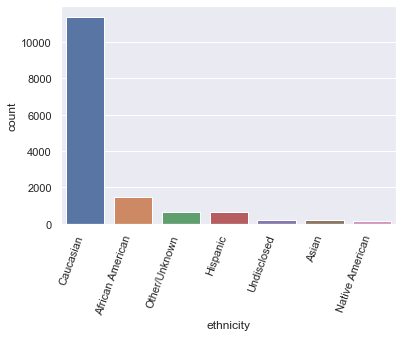

In [61]:
# Imputing values for ethnicity
X_cat.loc[:, 'ethnicity'] = X_cat['ethnicity'].fillna('Undisclosed')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['ethnicity'], order = X_cat['ethnicity'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

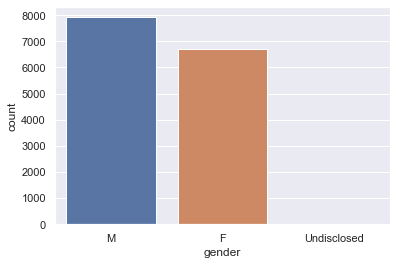

In [62]:
# Imputing values for gender
X_cat.loc[:, 'gender'] = X_cat['gender'].fillna('Undisclosed')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['gender'], order = X_cat['gender'].value_counts().index)
plt.show()

In [63]:
# Comparing unequal values of hospital_admit_source and icu_admit_source
X_cat[X_cat['hospital_admit_source']!=X_cat['icu_admit_source']]

,elective_surgery,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,readmission_status,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,0,Other/Unknown,M,NaN,Operating Room / Recovery,admit,Med-Surg ICU,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal
2,0,Caucasian,F,NaN,Accident & Emergency,admit,Med-Surg ICU,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
3,0,Caucasian,F,Acute Care/Floor,Floor,admit,Med-Surg ICU,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal
4,0,Caucasian,M,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
5,0,African American,M,NaN,Floor,admit,Med-Surg ICU,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
6,1,African American,M,Operating Room,Operating Room / Recovery,admit,CTICU,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
7,0,Caucasian,F,Acute Care/Floor,Floor,admit,Med-Surg ICU,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
8,1,Caucasian,M,Operating Room,Operating Room / Recovery,admit,Med-Surg ICU,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
9,0,Caucasian,M,Emergency Department,Accident & Emergency,admit,CSICU,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
11,0,Caucasian,F,Direct Admit,Accident & Emergency,admit,Med-Surg ICU,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


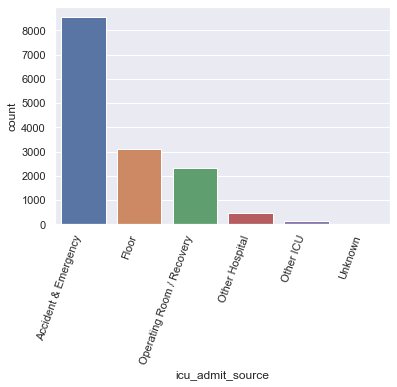

In [64]:
# Dropping hospital_admit_source and imputing missing values for icu_admit_source
X_cat = X_cat.drop(columns = 'hospital_admit_source', axis=1)
X_cat.loc[:, 'icu_admit_source'] = X_cat['icu_admit_source'].fillna('Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['icu_admit_source'], order = X_cat['icu_admit_source'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [65]:
# Comparing unequal values of apache_3j_bodysystem and apache_2_bodysystem
X_cat[X_cat['apache_3j_bodysystem']!=X_cat['apache_2_bodysystem']]

,elective_surgery,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,readmission_status,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
6,1,African American,M,Operating Room / Recovery,admit,CTICU,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
10,0,Caucasian,M,Floor,admit,CCU-CTICU,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hematological,Haematologic
13,0,Caucasian,M,Accident & Emergency,admit,Med-Surg ICU,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Genitourinary,Renal/Genitourinary
15,0,Caucasian,M,Other Hospital,admit,SICU,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hematological,Haematologic
18,0,Undisclosed,F,Floor,admit,Med-Surg ICU,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
21,0,Caucasian,F,Other ICU,transfer,Med-Surg ICU,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
29,0,Caucasian,M,Accident & Emergency,transfer,Cardiac ICU,0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
30,0,Caucasian,F,Accident & Emergency,admit,Med-Surg ICU,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
31,0,African American,F,Accident & Emergency,admit,Cardiac ICU,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
33,0,Other/Unknown,F,Accident & Emergency,admit,CCU-CTICU,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


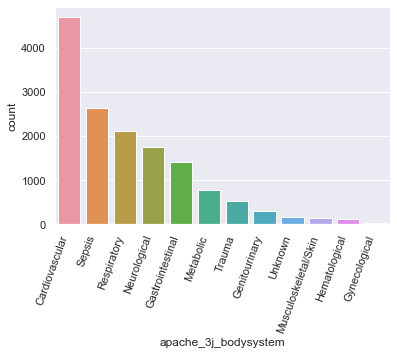

In [66]:
# Dropping apache_2_bodysystem and imputing missing values for apache_3j_bodysystem
X_cat = X_cat.drop(columns = 'apache_2_bodysystem', axis=1)
X_cat.loc[:, 'apache_3j_bodysystem'] = X_cat['apache_3j_bodysystem'].fillna('Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['apache_3j_bodysystem'], order = X_cat['apache_3j_bodysystem'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [67]:
X_cat.isnull().sum()

elective_surgery                0
ethnicity                       0
gender                          0
icu_admit_source                0
icu_stay_type                   0
icu_type                        0
readmission_status              0
apache_post_operative           0
arf_apache                     64
gcs_unable_apache              97
intubated_apache               64
ventilated_apache              64
aids                           64
cirrhosis                      64
diabetes_mellitus              64
hepatic_failure                64
immunosuppression              64
leukemia                       64
lymphoma                       64
solid_tumor_with_metastasis    64
apache_3j_bodysystem            0
dtype: int64

In [68]:
# Obtaining the index values of rows where arf_apache is NaN
idx = X_cat.index[X_cat['arf_apache'].isnull()].tolist()

# Dropping rows from X_cat
X_cat = X_cat.drop(X_cat.index[idx]).reset_index(drop=True)
print("The shape of X_cat after dropping rows is {}".format(X_cat.shape))

# Dropping rows from X_num
X_num = final_X[num_col]
X_num = X_num.drop(X_num.index[idx]).reset_index(drop=True)
print("The shape of X_num after dropping rows is {}".format(X_num.shape))

# Dropping corresponding rows from y
final_y = final_y.drop(final_y.index[idx]).reset_index(drop=True)
print("The shape of y after dropping rows is {}".format(final_y.shape))

The shape of X_cat after dropping rows is (14567, 21)
The shape of X_num after dropping rows is (14567, 120)
The shape of y after dropping rows is (14567,)


In [69]:
X_cat.isnull().sum()

elective_surgery                0
ethnicity                       0
gender                          0
icu_admit_source                0
icu_stay_type                   0
icu_type                        0
readmission_status              0
apache_post_operative           0
arf_apache                      0
gcs_unable_apache              33
intubated_apache                0
ventilated_apache               0
aids                            0
cirrhosis                       0
diabetes_mellitus               0
hepatic_failure                 0
immunosuppression               0
leukemia                        0
lymphoma                        0
solid_tumor_with_metastasis     0
apache_3j_bodysystem            0
dtype: int64

In [70]:
# Dropping gcs_unable_apache
X_cat = X_cat.drop(columns = 'gcs_unable_apache', axis=1)
X_cat.isnull().sum()

elective_surgery               0
ethnicity                      0
gender                         0
icu_admit_source               0
icu_stay_type                  0
icu_type                       0
readmission_status             0
apache_post_operative          0
arf_apache                     0
intubated_apache               0
ventilated_apache              0
aids                           0
cirrhosis                      0
diabetes_mellitus              0
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
apache_3j_bodysystem           0
dtype: int64

### Dealing with numerical variables

In [71]:
X_num.describe()

,age,bmi,pre_icu_los_days,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_inr_max,h1_inr_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
count,13822.000000,14007.000000,14567.000000,7248.000000,14471.000000,14518.000000,6573.000000,12549.000000,12584.000000,5348.000000,14285.000000,14285.000000,14285.000000,13636.000000,14564.000000,12407.000000,14553.000000,5348.000000,5348.000000,5348.000000,5348.000000,14533.000000,12679.000000,13980.000000,6438.000000,12056.000000,4897.000000,4897.000000,14562.000000,14562.000000,14404.000000,14404.000000,14565.000000,14565.00000,4946.000000,4946.000000,14561.000000,14561.000000,14341.000000,14341.000000,14538.000000,14538.000000,14533.000000,14533.000000,4902.000000,4902.00000,14563.000000,14563.000000,14406.000000,14406.000000,14167.000000,14167.000000,14152.000000,14152.000000,13638.000000,13638.000000,14271.000000,14271.000000,14017.000000,14017.000000,13402.000000,13402.000000,14042.000000,14042.000000,14028.000000,14028.000000,14153.000000,14153.000000,13638.000000,13638.000000,11103.000000,11103.000000,8182.000000,8182.000000,7372.000000,7372.000000,13825.000000,13825.000000,13386.000000,13386.000000,13838.000000,13838.000000,14284.000000,14284.000000,13110.000000,13110.000000,13545.000000,13545.000000,13596.00000,13596.000000,6744.000000,6744.000000,5772.000000,5772.000000,13344.000000,13344.000000,13950.000000,13950.000000,13907.000000,13907.000000,13364.000000,13364.000000,6810.000000,6810.000000,6744.000000,6744.000000,3712.000000,3712.000000,3641.000000,3641.000000,7724.000000,7724.000000,7532.000000,7532.000000,7720.000000,7720.000000,6365.000000,6365.000000,13581.000000,13581.000000
mean,65.073434,28.854290,1.094824,2.707892,174.040080,503.318892,1.556244,31.439166,1.744007,0.672062,3.082954,4.925936,3.418901,169.299685,105.084249,32.355646,85.661788,41.610266,41.610266,131.838295,7.327141,27.971162,138.095086,36.198383,1526.513830,13.534346,77.762508,43.428017,88.749416,46.452548,88.904888,46.535754,108.610436,70.30333,113.564294,56.549333,104.374631,60.085434,104.332264,60.167352,30.812904,12.965057,99.292231,87.325397,151.347205,85.28417,147.660029,90.191650,147.569763,90.273048,37.